In [37]:
import meep as mp

In [38]:
import numpy as np

In [39]:
resolution=5

In [40]:
w=1 #width of the waveguide
l=10  #Coupler length
s=0.21 #Separation between waveguides
m=2; # number of parallel waveguides since n is refractive index of core
# l from left and right difference between one mzi and another mzi below and 3l is the length of mzi, so total difference between two       
# mzis of terminal waveguides is 5l; going below for starting point of another waveguides differs by 4l, 3l for mzi plus a difference
e=0.027 #error between base  and height of peak;subject to slope of tanh function and coupling length(l)
p=2 # Base to peak length subject to coefficients of product of tanh functions
gap= s+w+2*p-2*e #difference in heights between boundaries of consecutive waveguides
sl=2 #Controlling slope
y_max=(m-1)*gap+w #maximal y_coordinate of computational domain
x_max=(8*m-13)*l/2

In [41]:
 cell = mp.Vector3(2*x_max+16,y_max+3,0)

In [42]:
arr=[]

In [43]:
arr.append([0.2])

In [44]:
print(arr[0][0])

0.2


In [45]:
import numpy as np
from scipy.ndimage import gaussian_filter
import meep as mp  # Ensure you have the meep package installed


dxy = 1 / resolution  # smoothing kernel radius
Nxy = 5  # smoothing grid pixel density
n = 3.4  # refractive index for the material, replace with the correct value

def ring_resonator(pos):
    # Define the ring resonator function here
    # This function should return the index of refraction at the given position
    # For example:
    p=0
    x=pos.x
    y=pos.y
    x_m=x_max
    y_m=y_max

    for i in range(0,m,1):
        if(i==0):
            y1=y_m/2-2*(m-1)
            y2=y_m/2-w-2*(m-1)
            for j in range(0,m-1,1):
                
                one=np.tanh((x+x_m)/sl)*np.tanh((x+x_m-l)/sl)+np.tanh((x+x_m-2*l)/sl)*np.tanh((x+x_m-3*l)/sl)
                y1+=one
                y2+=one
                x_m=x_m-8*l
                p+=+arr[i][j]+one*arr[i][j]
            if(y2<y<y1):
                p+=1
                return n*p
            else:
                p=0
                x_m=x_max
        else:
            y1=y_m/2+2
            y2=y_m/2-w+2
            for j in range(0,2*(m-i)-1,1):
                #print("IN LOOP")
                one=np.tanh((x+x_m)/sl)*np.tanh((x+x_m-l)/sl)+np.tanh((x+x_m-2*l)/sl)*np.tanh((x+x_m-3*l)/sl)
                zero=-np.tanh((x+x_m)/sl)*np.tanh((x+x_m-l)/sl)-np.tanh((x+x_m-2*l)/sl)*np.tanh((x+x_m-3*l)/sl)
                if(j%2!=0):
                    y1+=one
                    y2+=one
                    p+=+arr[i][j//2]+one*arr[i][j//2]
                else:
                    y1+=zero
                    y2+=zero
                    p+=-arr[i-1][j//2]+zero*arr[i-1][j//2]
                x_m=x_m-4*l
            if(y2<y<y1):
                p+=1
                return n*p
            else:
                p=0
                x_m=x_max-4*i*l
        y_m=y_m-2*gap
    #print("Yes#")
    return 1
                
            
        

    
    
    
        
def smooth_ring_resonator(p):
    cx = np.linspace(p.x - 0.5 * dxy, p.x + 0.5 * dxy, Nxy)
    cy = np.linspace(p.y - 0.5 * dxy, p.y + 0.5 * dxy, Nxy)
    n_local = np.zeros((Nxy, Nxy))
    for i in range(Nxy):
        for j in range(Nxy):
            n_local[i, j] = ring_resonator(mp.Vector3(cx[i], cy[j]))
    if np.sum(n_local) == Nxy**2:
        return mp.air
    elif np.sum(n_local) == n * Nxy**2:
        return mp.Medium(index=n)
    else:
        return mp.Medium(index=np.mean(gaussian_filter(n_local, sigma=1, mode='nearest')))
   


sxy =2*x_max+16  # Define the size of the block in the xy-plane
syx=y_max+3

geometry = [mp.Block(center=mp.Vector3(),
                     size=mp.Vector3(sxy, syx),
                     material=smooth_ring_resonator)]

# Continue with the rest of your Meep simulation setup


In [46]:
rot_angle = np.radians(20)

w = 1.0 # width of waveguide


fsrc = 0.15 # frequency of eigenmode or constant-amplitude source
bnum = 1    # band number of eigenmode

kpoint = mp.Vector3(x=1).rotate(mp.Vector3(z=1), rot_angle)

compute_flux = True # compute flux (True) or plot the field profile (False)

eig_src = True # eigenmode (True) or constant-amplitude (False) source

if eig_src:
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fsrc,fwidth=0.2*fsrc) if compute_flux else mp.ContinuousSource(fsrc),
                                  center=mp.Vector3(-x_max-5,y_max/2-w/2-e),
                                  size=mp.Vector3(y=3*w),
                                  direction=mp.NO_DIRECTION,
                                  eig_kpoint=kpoint,
                                  eig_band=bnum,
                                  eig_parity=mp.EVEN_Y+mp.ODD_Z if rot_angle == 0 else mp.ODD_Z,
                                  eig_match_freq=True)]
else:
    sources = [mp.Source(src=mp.GaussianSource(fsrc,fwidth=0.2*fsrc) if compute_flux else mp.ContinuousSource(fsrc),
                         center=mp.Vector3(-x_max-5,y_max/2-w/2-e),
                         size=mp.Vector3(y=3*w),
                         component=mp.Ez)]

In [47]:
#sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
                     #component=mp.Ez,
                     #center=mp.Vector3(-x_max-5,y_max/2-w/2-e))]

In [48]:
pml_layers = [mp.PML(1.0)]

In [49]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [50]:
fcen=fsrc
df=0
nfreq = 1  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-x_max,y_max/2-w/2-e), size=mp.Vector3(0,4*w,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr1 = mp.FluxRegion(center=mp.Vector3(+x_max-2*l,y_max/2-2+w/2+e), size=mp.Vector3(0,2*w,0))
tran1 = sim.add_flux(fcen, df, nfreq, tran_fr1)

# transmitted flux
tran_fr2 = mp.FluxRegion(center=mp.Vector3(+x_max-2*l,-y_max/2+2-w/2-e), size=mp.Vector3(0,2*w,0))
tran2 = sim.add_flux(fcen, df, nfreq, tran_fr2)

# transmitted flux
tran_fr11 = mp.FluxRegion(center=mp.Vector3(+x_max-l,y_max/2-2+w/2+e), size=mp.Vector3(0,2*w,0))
tran11 = sim.add_flux(fcen, df, nfreq, tran_fr11)

# transmitted flux
tran_fr22 = mp.FluxRegion(center=mp.Vector3(+x_max-l,-y_max/2+2-w/2-e), size=mp.Vector3(0,2*w,0))
tran22 = sim.add_flux(fcen, df, nfreq, tran_fr22)

# transmitted flux
tran_fr111 = mp.FluxRegion(center=mp.Vector3(+x_max,y_max/2-2+w/2+e), size=mp.Vector3(0,2*w,0))
tran111 = sim.add_flux(fcen, df, nfreq, tran_fr111)

# transmitted flux
tran_fr222 = mp.FluxRegion(center=mp.Vector3(+x_max,-y_max/2+2-w/2-e), size=mp.Vector3(0,2*w,0))
tran222 = sim.add_flux(fcen, df, nfreq, tran_fr222)

In [51]:
sim.run(mp.at_beginning(mp.output_epsilon),
        mp.to_appended("ez", mp.at_every(0.6, mp.output_efield_z)),
        until=600)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000256777 s
Working in 2D dimensions.
Computational cell is 46 x 9.2 x 0 with resolution 5
     block, center = (0,0,0)
          size (46,9.156,0)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 91.3112% done, 0.442972 s remaining
subpixel-averaging is 91.3112% done, 0.442482 s remaining
subpixel-averaging is 91.3112% done, 0.443368 s remaining
time for set_epsilon = 21.9949 s
-----------


MPB solved for frequency_1(0.939693,0.34202,0) = 0.204649 after 12 iters
MPB solved for frequency_1(0.65032,0.236697,0) = 0.150103 after 9 iters
MPB solved for frequency_1(0.649771,0.236497,0) = 0.15 after 5 iters
MPB solved for frequency_1(0.649771,0.236497,0) = 0.15 after 1 iters


FloatProgress(value=0.0, description='0% done ', max=600.0)

creating output file "./eps-000000.00.h5"...
creating output file "./ez.h5"...
run 0 finished at t = 600.0 (6000 timesteps)


In [52]:
incident_flux = mp.get_fluxes(refl)

In [53]:
output1=mp.get_fluxes(tran1)

In [54]:
output11=mp.get_fluxes(tran11)

In [55]:
output111=mp.get_fluxes(tran111)

In [56]:
output2=mp.get_fluxes(tran2)

In [57]:
output22=mp.get_fluxes(tran22)

In [58]:
output222=mp.get_fluxes(tran222)

In [59]:
print(incident_flux[0]/incident_flux[0])

1.0


In [60]:
print(output1[0]/incident_flux[0])

0.9267791732830897


In [61]:
print(output11[0]/incident_flux[0])

0.915045085124371


In [62]:
print(output111[0]/incident_flux[0])

0.9183567449790594


In [63]:
print(output2[0]/incident_flux[0])

0.03357067312521073


In [64]:
print(output22[0]/incident_flux[0])

0.024243723664893763


In [65]:
print(output222[0]/incident_flux[0])

0.014452000492211245


In [66]:
import numpy as np
import matplotlib.pyplot as plt

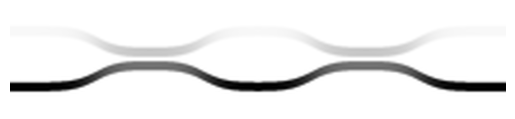

In [67]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()


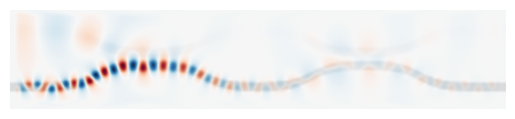

In [68]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

In [69]:
!h5ls ez.h5

ez                       Dataset {230, 46, 1000/Inf}


In [70]:
!h5topng -t 0:900 -R -Zc dkbluered -a yarg -A eps-000000.00.h5 ez.h5

In [71]:
!convert ez.t*.png ez.gif

FloatProgress(value=600.0, description='0% done ', max=800.0, min=600.0)

creating output file "./eps-000600.00.h5"...
on time step 6000 (time=600), 0.0117764 s/step
run 1 finished at t = 800.0 (8000 timesteps)


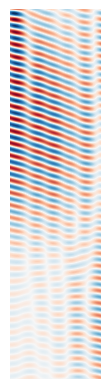

In [72]:
vals = []

def get_slice(sim):
    vals.append(sim.get_array(center=mp.Vector3(0,-3.5), size=mp.Vector3(16,0), component=mp.Ez))

sim.run(mp.at_beginning(mp.output_epsilon),
        mp.at_every(0.6, get_slice),
        until=200)

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(vals, interpolation='spline36', cmap='RdBu')
plt.axis('off')
plt.show()